In [104]:
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
options = Options()
options.binary_location = 'geckodriver'
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import seaborn as sns



In [105]:
import time
from urllib.request import Request, urlopen
from urllib.error import HTTPError

base_url = "https://www.infocasas.com.uy/alquiler/inmuebles/pagina"

total_pages = 50

html_base = []

max_retries = 3

retry_delay = 1

for page_number in range(1, total_pages + 1):

    # Construye la URL completa para la página actual
    url = f"{base_url}{page_number}"

    request = Request(url)

    for retry in range(max_retries):
        try:
            response = urlopen(request)

            html = response.read()

            html_base.append(html)

            # Hay que cerrar la conexión no seas rata!!!!!
            response.close()

            break

        except HTTPError as e:
            print(f"HTTP Error: {e.code} - {e.reason}")

            time.sleep(retry_delay)

            retry_delay *= 2

    else:
        
        print(f"Maximum number of retries reached for page {page_number}. Request failed.")



In [106]:
sopita = []

for html in html_base:
    soup = BeautifulSoup(html, 'lxml')

    sopita.append(soup)

In [107]:
    links_array = []

    for soup in sopita:
        links = soup.find_all('a', class_='lc-cardCover')
        links_array.extend(links)

In [108]:
urls = [link['href'] for link in links_array]
urls = [f"https://www.infocasas.com.uy{link}" for link in urls]

In [109]:
len(urls)

1050

In [110]:
html_data = []

max_retries = 3

retry_delay = 1

for index, url in enumerate(urls, start=1):
    request = Request(url)

    for retry in range(max_retries):
        try:
            response = urlopen(request)

            html = response.read()

            html_data.append(html)

            # cerra la conexión dale!!!!
            response.close()

            break

        except HTTPError as e:
            print(f"HTTP Error: {e.code} - {e.reason} on page {index}")

            time.sleep(retry_delay)

            # Increase the delay for the next retry
            retry_delay *= 2

    else:
        print(f"Maximum number of retries reached for page {index}. Request failed.")


HTTP Error: 404 - Not Found on page 562
HTTP Error: 404 - Not Found on page 562
HTTP Error: 404 - Not Found on page 562
Maximum number of retries reached for page 562. Request failed.
HTTP Error: 404 - Not Found on page 897
HTTP Error: 404 - Not Found on page 897
HTTP Error: 404 - Not Found on page 897
Maximum number of retries reached for page 897. Request failed.


In [111]:
print(f"Se obtuvo información de {len(html_data)} casas , faltaron {len(urls) - len(html_data)} .")

Se obtuvo información de 1048 casas , faltaron 2 .


In [112]:
prices = []
for html in html_data:
    price_element = BeautifulSoup(html, 'lxml').find('span', class_='ant-typography price')
    if price_element:
        price = price_element.text
        prices.append(price)
    else:
        prices.append('N/A')


In [113]:
gastos_list = []

for html in html_data:
    gastos_tags = BeautifulSoup(html, 'lxml').find_all('span', class_='ant-typography ant-typography-secondary commonExpenses')
    if gastos_tags:  # Verificar si hay elementos encontrados
        gastos_text = ''.join(tag.text for tag in gastos_tags)  # Unir el texto de todos los elementos encontrados
        gastos_list.append(gastos_text)
    else:
        gastos_list.append('0') 

In [114]:
import json
from bs4 import BeautifulSoup

casas = []

for html_content in html_data:
    soup = BeautifulSoup(html_content, 'html.parser')
    script_tag = soup.find('script', {'id': '__NEXT_DATA__'})
    json_text = script_tag.string if script_tag else '{}'
    data = json.loads(json_text)
    
    if 'props' in data and 'pageProps' in data['props'] and 'apolloState' in data['props']['pageProps']:
        property_keys = [key for key in data['props']['pageProps']['apolloState'].keys() if key.startswith('Property:')]
        
        if property_keys:
            technical_sheet = data['props']['pageProps']['apolloState'][property_keys[0]].get('technicalSheet', [])
            

            formatted_technical_sheet_tuples = [(item['text'], item['value']) for item in technical_sheet]
            
            casas.append(formatted_technical_sheet_tuples)

In [115]:
for i in range(len(casas)):
    casas[i].append(('Precio', prices[i]))


In [116]:
todos_los_nombres = set()
for casa in casas:
    for nombre, _ in casa:
        todos_los_nombres.add(nombre)

datos_dict = {}
for i, casa in enumerate(casas):
    casa_dict = dict(casa)
    datos_dict[i] = casa_dict

df = pd.DataFrame.from_dict(datos_dict, orient='index')

df = df.reindex(sorted(todos_los_nombres), axis=1)



In [117]:
# los nan son strings vacios, los reemplazo por np.nan
df.replace('', np.nan, inplace=True)

/tmp/ipykernel_2247/3230795436.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('', np.nan, inplace=True)


In [118]:
df.drop('Contrato Mínimo', axis=1, inplace=True)
df.drop('Acepta mascotas', axis=1, inplace=True)



In [119]:
df.head()


,Apartamentos por Pisos,Año de Construcción,Barrio Privado,Baños,Cantidad de Pisos,Disposición,Dormitorios,Estado,Garajes,Gastos Comunes,...,M² del terreno,M² edificados,Piso,Plantas,Precio,Referencia,Sobre,Tipo de Propiedad,Vivienda Social,Zona
0,NaN,2016,NaN,1,NaN,Al frente,1,Buen estado,1,$ 5.600,...,45 m2,NaN,9,1,"$ 32,000",A43C29,No aplica,Apartamento,NaN,Villa Biarritz
1,NaN,NaN,NaN,4,NaN,No aplica,3,Buen estado,NaN,NaN,...,1.000 m2,NaN,NaN,NaN,"U$S 3,950",Z6132A,No aplica,Casa,NaN,La Barra
2,NaN,NaN,NaN,8,NaN,No aplica,6,Buen estado,NaN,NaN,...,1.100 m2,300 m2,NaN,NaN,"U$S 5,500",V8F603,No aplica,Casa,NaN,La Barra
3,NaN,NaN,NaN,1,10,No aplica,NaN,Sin Definir,1,$ 17.000,...,NaN,110 m2,NaN,1,"$ 49,000",H38772,No aplica,Apartamento,NaN,Malvín
4,NaN,2024,NaN,3,NaN,No aplica,3,A estrenar,NaN,NaN,...,350 m2,210 m2,NaN,1,"U$S 4,000",E1FB8C,No aplica,Casa,NaN,Carrasco Barrios con Seguridad


In [120]:
df['M² de terraza'] = df['M² de terraza'].str.extract('(\d+)').astype(float)
df['M² edificados'] = df['M² edificados'].str.extract('(\d+)').astype(float)
df['M² del terreno'] = df['M² del terreno'].str.extract('(\d+)').astype(float)


In [121]:
df['Precio'] = df['Precio'].str.replace('.', '')
df['Precio'] = df['Precio'].str.replace(',', '')

df[['Moneda', 'Monto']] = df['Precio'].str.split(' ', n=1, expand=True)
df['Monto'] = df['Monto'].astype(float)
df.drop('Precio', axis=1, inplace=True)


In [122]:
df.loc[df['Moneda'] == 'U$S', 'Monto'] *= 40


In [123]:
df['Sobre'] = df['Sobre'].replace('No aplica', np.nan)
df['Sobre'] = df['Sobre'].replace('Otros', np.nan)


<Axes: xlabel='Moneda', ylabel='Monto'>

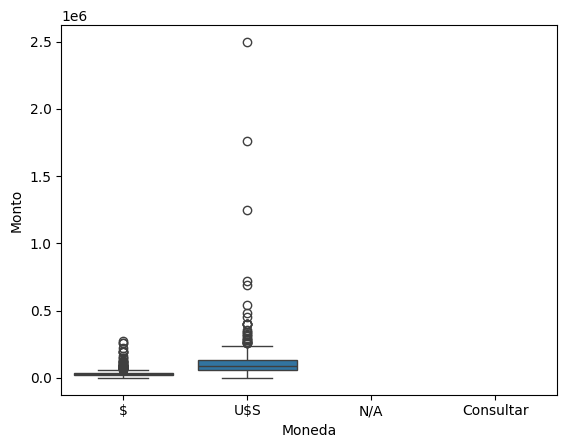

In [124]:
sns.boxplot(x='Moneda', y='Monto', data=df)

<Axes: xlabel='Monto', ylabel='Count'>

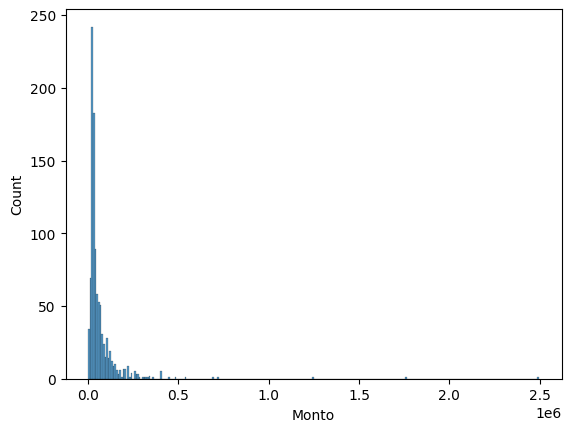

In [125]:
sns.histplot(df['Monto'])

In [126]:
df['Año de Construcción'] = pd.to_numeric(df['Año de Construcción'], errors='coerce')
df['Baños'] = pd.to_numeric(df['Baños'], errors='coerce')
df['Dormitorios'] = pd.to_numeric(df['Dormitorios'], errors='coerce')
df['Garajes'] = pd.to_numeric(df['Garajes'], errors='coerce')
df['Plantas'] = pd.to_numeric(df['Plantas'], errors='coerce')
df['Apartamentos por Pisos'] = pd.to_numeric(df['Apartamentos por Pisos'], errors='coerce')
df['Piso'] = pd.to_numeric(df['Piso'], errors='coerce')
df['Gastos Comunes'] = pd.to_numeric(df['Gastos Comunes'], errors='coerce')


In [127]:
df = df.drop('Referencia', axis=1)


In [128]:
df['Sobre'] = df['Sobre'].astype('category')
df['Disposición'] = df['Disposición'].astype('category')
df['Zona'] = df['Zona'].astype('category')
df['Barrio Privado'] = df['Barrio Privado'].astype('category')
df['Estado'] = df['Estado'].astype('category')
df['Tipo de Propiedad'] = df['Tipo de Propiedad'].astype('category')
df['Moneda'] = df['Moneda'].astype('category')
df['Vivienda Social'] = df['Vivienda Social'].astype('category')

In [129]:
df.to_csv('data.csv', index=False)